In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import shutil

# Try to remove the tree; if it fails, throw an error using try...except.
try:
    shutil.rmtree("/content/sample_data")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
# Clone from Github Repository
! git init .
! git remote add origin https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN.git
# ! git pull origin master
! git pull origin main

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 29 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), 22.41 KiB | 2.24 MiB/s, done.
From https://github.com/RichardMinsooGo-ML/Bible_4_Part_J_K_Pytorch_SSD_Retinanet_Faster_R_CNN
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [4]:
# VOC 2012 Dataset Download and extract

! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [5]:
!tar -xvf "/content/VOCtrainval_11-May-2012.tar" -C "/content/dataset"
clear_output()

In [6]:
! python src/xml2json.py ./dataset/VOCdevkit 2012

5717
5823
11540


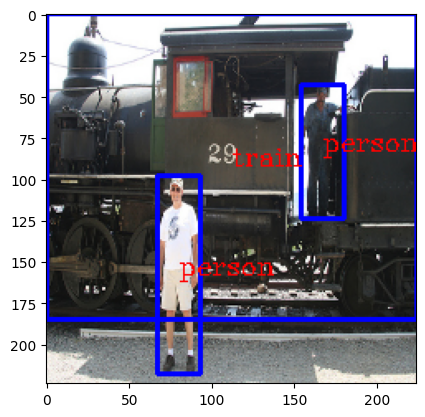

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.ops import nms, RoIPool

from src import display
from src import data_transformer as dt
from src.evaluation import PredBoundingBox, MAP, center_to_minmax
from src.augmentations import RandomHorizontalFlip, RandomContrast
from src.faster_rcnn_utils import generator_anchors, loc2bbox, bbox2loc, random_choice, normal_init

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def intersect(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def box_area(box: torch.Tensor) -> float:
    return (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])


def jaccard(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    intersection = intersect(box_a, box_b)
    union = box_area(box_a).unsqueeze(1) + box_area(box_b).unsqueeze(0) - intersection
    return intersection / union

IMG_PATH        = "./dataset/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path   = "./dataset/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

target_size = 224
num_classes = 20

seed = 42
device = "cuda"

data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

example = data_list[0]
example

img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [8]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std  = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std

        img = torch.from_numpy(img).float()

        gt = torch.from_numpy(gt).float()
        gt = center_to_minmax(gt)
        c = torch.from_numpy(np.array(item.class_id))

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset   = PascalData(data_list[split_idx:])
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

class ProposalLayer(nn.Module):
    def __init__(self, img_size, nms_thresh=0.7, n_train_pre_nms=2000, n_train_post_nms=1000,
                 n_test_pre_nms=600, n_test_post_nms=300, min_size=16):

        super().__init__()
        self.img_size = img_size
        self.nms_threshold = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def forward(self, locs, scores, anchors):
        if self.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        roi = loc2bbox(anchors, locs)
        roi = torch.clamp(roi, 0, self.img_size)

        # Remove predicted boxes with either height or width < threshold.
        widths = roi[:, 2] - roi[:, 0]
        heights = roi[:, 3] - roi[:, 1]
        keep = torch.where((heights >= self.min_size) & (widths >= self.min_size))[0]

        roi = roi[keep, :]
        scores = scores[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest and the the n_pre_nms highest.
        indicies = torch.argsort(scores, descending=True)
        indicies = indicies[:n_pre_nms]
        roi = roi[indicies, :]
        scores = scores[indicies]

        keep = nms(roi, scores, self.nms_threshold)
        keep = keep[:n_post_nms]
        roi = roi[keep]

        return roi

class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, in_channels=256, mid_channels=256, ratios=[0.7, 1, 1.3],
                 anchor_scales=[4, 8, 16], sub_sample=16):
        super().__init__()

        # Note: all images in the forward pass need to be of shape 3 x img_size x img_size
        self.img_size = img_size
        self.anchors = generator_anchors(img_size // sub_sample, sub_sample, anchor_scales=anchor_scales, ratios=ratios)
        self.num_base_anchors = len(ratios) * len(anchor_scales)

        self.proposal_layer = ProposalLayer(img_size)

        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.score = nn.Conv2d(mid_channels, 2 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)
        self.loc = nn.Conv2d(mid_channels, 4 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)

        normal_init(self.conv, 0.0, 0.01)
        normal_init(self.score, 0.0, 0.01)
        normal_init(self.loc, 0.0, 0.01)

    def forward(self, x):
        n, _, height, width = x.shape
        h = F.relu(self.conv(x))

        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()

        rpn_softmax_scores = F.softmax(rpn_scores.view(n, height, width, self.num_base_anchors, 2), dim=4)

        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = []
        roi_indices = []
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], self.anchors)
            batch_index = i * torch.ones((len(roi),)).int()
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = torch.cat(rois, dim=0).to(device)
        roi_indices = torch.cat(roi_indices, dim=0).to(device)
        return rpn_locs, rpn_scores, rois, roi_indices

class RoIHead(nn.Module):
    def __init__(self, num_classes, output_size, num_hidden=256, in_channels=256, sub_sample=16, p=0.1):
        super().__init__()

        self.linear = nn.Linear(output_size * output_size * in_channels, num_hidden)
        self.cls_loc = nn.Linear(num_hidden, 4 * num_classes)
        self.score = nn.Linear(num_hidden, num_classes)
        self.roi_pool = RoIPool(output_size, spatial_scale=1/sub_sample)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.dropout = nn.Dropout(p=p)

    def forward(self, x, rois, roi_indices):
        indicies_and_rois = torch.cat([
            roi_indices.float().unsqueeze(-1),
            rois
        ], dim=1)

        pool_vals = self.roi_pool(x, indicies_and_rois)
        pool_vals = pool_vals.view(pool_vals.size(0), -1)

        h = F.relu(self.linear(pool_vals))
        h = self.dropout(h)
        roi_cls_locs = self.cls_loc(h)
        roi_scores = self.score(h)
        return roi_cls_locs, roi_scores

class FasterRCNN(nn.Module):
    def __init__(self, img_size, num_classes, output_size=7):
        super().__init__()

        self.img_size = img_size
        self.num_classes = num_classes
        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-3]
        self.backbone = nn.Sequential(*pretrained_model)
        self.region_proposal_network = RegionProposalNetwork(img_size, sub_sample=16)
        self.roi_head = RoIHead(num_classes, output_size)

    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward_rpn(self, x):
        feature_map = self.backbone(x)
        rpn_locs, rpn_scores, rois, roi_indices = self.region_proposal_network(feature_map)
        return rpn_locs, rpn_scores, rois, roi_indices, feature_map

    def forward_roi(self, x, rois, roi_indices):
        roi_cls_locs, roi_scores = self.roi_head(x, rois, roi_indices)
        return roi_cls_locs, roi_scores

    def predict(self, x):
        # Forward for inference
        # Currently only support batch_size=1
        assert len(x.shape) == 4 and x.shape[0] == 1

        rpn_locs, rpn_scores, rois, roi_indices, feature_map = self.forward_rpn(x)
        roi_cls_locs, roi_scores = self.forward_roi(feature_map, rois, roi_indices)

        cls_boxes = loc2bbox(rois, roi_cls_locs)
        cls_boxes = torch.clamp(cls_boxes, min=0, max=self.img_size)

        roi_scores = F.softmax(roi_scores, dim=1)
        roi_scores, classes_idx = torch.max(roi_scores, dim=1)

        keep_boxes = []
        for i in range(len(classes_idx)):
            c = classes_idx[i]
            keep_boxes.append(cls_boxes[None, i, 4*c:4*(c+1)])
        cls_boxes = torch.cat(keep_boxes, dim=0)

        keep = classes_idx > 0
        cls_boxes = cls_boxes[keep, :]
        roi_scores = roi_scores[keep]
        classes_idx = classes_idx[keep]

        return roi_scores, classes_idx, cls_boxes

def sample_labels(labels, n_sample=256, pos_ratio=0.5):
    n_pos = pos_ratio * n_sample

    pos_index = torch.where(labels == 1)[0]
    if len(pos_index) > n_pos:
        disable_index = random_choice(pos_index, size=int(len(pos_index) - n_pos))
        labels[disable_index] = -1

    n_neg = n_sample - torch.sum(labels == 1)
    neg_index = torch.where(labels == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = random_choice(neg_index, size=int(len(neg_index) - n_neg))
        labels[disable_index] = -1

    return labels


def create_anchor_labels(anchors, gt, img_size, pos_iou_threshold=0.7, neg_iou_threshold=0.3,
                         n_sample=256, pos_ratio=0.5):
    index_inside = torch.where((anchors[:, 0] >= 0) &
                               (anchors[:, 1] >= 0) &
                               (anchors[:, 2] <= img_size) &
                               (anchors[:, 3] <= img_size))[0]

    labels = -1 * torch.ones((len(index_inside), )).int()
    valid_anchor_boxes = anchors[index_inside]

    ious = jaccard(valid_anchor_boxes, gt)

    argmax_ious = ious.argmax(dim=1)
    max_ious = ious[torch.arange(len(index_inside)), argmax_ious]

    gt_argmax_ious = ious.argmax(dim=0)

    gt_max_ious = ious[gt_argmax_ious, torch.arange(ious.shape[1])]
    gt_argmax_ious = torch.where(ious == gt_max_ious)[0]

    labels[max_ious < neg_iou_threshold] = 0
    labels[gt_argmax_ious] = 1
    labels[max_ious >= pos_iou_threshold] = 1

    labels = sample_labels(labels, n_sample, pos_ratio)

    locs = bbox2loc(valid_anchor_boxes, gt[argmax_ious])

    anchor_labels = -1 * torch.ones((len(anchors),)).int()
    anchor_labels[index_inside] = labels
    anchor_labels = anchor_labels.long().to(device)

    anchor_locations = torch.zeros_like(anchors)
    anchor_locations[index_inside, :] = locs
    anchor_locations = anchor_locations.to(device)

    return anchor_labels, anchor_locations


def create_target_labels(rois, gt_boxes, label):
    n_sample = 128
    pos_ratio = 0.25
    pos_iou_thresh = 0.5
    neg_iou_thresh_hi = 0.5
    neg_iou_thresh_lo = 0.0
    loc_normalize_mean = torch.tensor([0.0, 0.0, 0.0, 0.0]).view((1, 4)).float().to(device)
    loc_normalize_std = torch.tensor([1.0, 1.0, 1.0, 1.0]).view((1, 4)).float().to(device)

    # Rois comes from the network, we need to disable the grad tracing,
    # since we do some ops which are not differentiable
    with torch.no_grad():
        pos_roi_per_image = np.round(n_sample * pos_ratio)
        iou = jaccard(rois, gt_boxes)

        gt_assignment = iou.argmax(dim=1)
        max_iou = iou.max(axis=1)[0]

        gt_roi_label = label[gt_assignment]

        pos_index = torch.where(max_iou >= pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, len(pos_index)))

        if len(pos_index) > 0:
            pos_index = random_choice(pos_index, pos_roi_per_this_image)

        neg_index = torch.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, len(neg_index)))

        if len(neg_index) > 0:
            neg_index = random_choice(neg_index, neg_roi_per_this_image)

        keep_index = torch.cat([pos_index, neg_index], dim=0)

        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels becomes background
        sample_roi = rois[keep_index]

        gt_roi_loc = bbox2loc(sample_roi, gt_boxes[gt_assignment[keep_index]])
        gt_roi_loc = (gt_roi_loc - loc_normalize_mean) / loc_normalize_std
    return sample_roi, gt_roi_loc, gt_roi_label

torch.manual_seed(seed)
model = FasterRCNN(target_size, num_classes + 1) # 1 class for background
model = model.to(device)
model.change_freezing(False)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 184MB/s]


In [9]:
n_epochs = 100
lr = 1e-3
wd = 1e-3
roi_lambda = 1.0

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

def filter_smooth_l1(target, pred, labels, ignore_idx=-1):
    filter_target = target[labels != ignore_idx, :]
    filter_pred = pred[labels != ignore_idx, :]
    loss = F.smooth_l1_loss(filter_target, filter_pred, reduction="none")
    return torch.sum(loss) / len(filter_target)

from collections import defaultdict

class FasterMAP:
    def __init__(self, model, dataset, jaccard_threshold):
        self.jaccard_threshold = jaccard_threshold
        self.model = model
        self.dataset = dataset
        self.eps = np.finfo(np.float32).eps

    @staticmethod
    def voc_ap(rec, prec):
        """Compute VOC AP given precision and recall with the VOC-07 11-point method."""

        ap = 0.0
        for t in np.arange(0.0, 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0.0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.0
        return ap

    def __call__(self):
        self.model.eval()
        aps = defaultdict(list)

        with torch.no_grad():
            for i in range(len(val_dataset)):
                (x, bb_true, class_true) = val_dataset[i]
                bb_true, x = bb_true.to(device), x.to(device)

                class_true = class_true - 1 # -1 to convert it from 1-21 to 0-20

                x = x[None, :, :, :]
                prob, class_idx, bb_hat = model.predict(x)
                _, prob_idx = torch.sort(prob, descending=True)

                bb_hat = bb_hat[prob_idx, :]
                class_idx = class_idx[prob_idx]
                class_idx = class_idx - 1

                jacard_values = jaccard(bb_hat, bb_true)

                for j in range(len(class_true)):
                    overlap = (jacard_values[:, j] > self.jaccard_threshold).nonzero()
                    class_true_j = int(class_true[j].detach().cpu().numpy())

                    if len(overlap) > 0:
                        class_id = class_idx[overlap[:,0]].cpu().numpy()

                        # Below is the same
                        tp = np.zeros_like(class_id)
                        fp = np.zeros_like(class_id)

                        found = False
                        for d in range(len(class_id)):
                            if found or class_id[d] != class_true[j]:
                                fp[d] = 1.0
                            else:
                                tp[d] = 1.0
                                found = True

                        fp = np.cumsum(fp)
                        tp = np.cumsum(tp)

                        rec = tp
                        prec = tp / np.maximum(tp + fp, self.eps)

                        temp_ap = MAP.voc_ap(rec, prec)
                        aps[class_true_j].append(temp_ap)
                    else:
                        aps[class_true_j].append(0)

        res_list = []
        for _, list_value in aps.items():
            res_list.append(sum(list_value) / len(list_value))

        return res_list, sum(res_list) / len(res_list)

def loss(x, gt, c, rpn_locs, rpn_scores, rois, roi_indices, feature_map):
    rpn_cls_loss, rpn_loc_loss = 0.0, 0.0
    roi_cls_loss, roi_loc_loss = 0.0, 0.0
    for i in range(len(x)):
        gt_i = gt[i].to(device)
        c_i = c[i].to(device)
        rois_i = rois[roi_indices == i]

        # RPN loss
        anchors = generator_anchors(target_size  // 16, sub_sample=16)
        anchor_labels, anchor_locations = create_anchor_labels(anchors, gt_i, target_size)

        rpn_cls_loss += F.cross_entropy(rpn_scores[i, :, :], anchor_labels, ignore_index = -1)

        temp_loss = F.smooth_l1_loss(anchor_locations, rpn_locs[i, :, :], reduction="none")
        label_filter = (anchor_labels > 0).float().unsqueeze(-1)
        temp_loss = temp_loss * label_filter
        rpn_loc_loss += torch.sum(temp_loss) / max(torch.sum(label_filter), 1)

        # ROI loss
        sample_roi, gt_roi_loc, gt_roi_label = create_target_labels(rois_i, gt_i, c_i)

        sample_roi_index = torch.zeros(len(sample_roi)).to(device)
        roi_cls_loc, roi_score = model.forward_roi(
            feature_map[i, :, :, :].unsqueeze(0),
            sample_roi,
            sample_roi_index)

        roi_cls_loss += F.cross_entropy(roi_score, gt_roi_label)

        n_sample = roi_cls_loc.shape[0]
        roi_loc = roi_cls_loc.view(n_sample, -1, 4)
        roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]

        temp_roi_loss = F.smooth_l1_loss(roi_loc, gt_roi_loc, reduction="none")
        roi_label_filter = (gt_roi_label > 0).float().unsqueeze(-1)
        temp_roi_loss = temp_roi_loss * roi_label_filter
        roi_loc_loss += torch.sum(temp_roi_loss) / max(torch.sum(roi_label_filter), 1)

    rpn_loss = rpn_cls_loss  + rpn_loc_loss
    roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss

    return rpn_loss, roi_loss

map_eval = FasterMAP(model, val_dataset, 0.5)

torch.manual_seed(seed)
random.seed(seed)

In [10]:
from tqdm import tqdm, tqdm_notebook, trange

for epoch in range(n_epochs):
    model.train()

    train_loss = 0.0
    with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:
        for idx, (x, gt, c) in enumerate(train_loader):
            model.zero_grad()

            x = x.to(device)
            rpn_locs, rpn_scores, rois, roi_indices, feature_map = model.forward_rpn(x)

            batch_rpn_loss, batch_roi_loss = loss(x, gt, c, rpn_locs, rpn_scores, rois, roi_indices, feature_map)
            batch_loss = (batch_rpn_loss + batch_roi_loss) / len(x)

            batch_loss.backward()
            optimizer.step()

            train_loss       += batch_loss.detach().cpu().numpy()

            pbar.update(1)

        train_loss = np.round(train_loss / len(train_loader), 6)

    val_loss = 0.0
    model.eval()

    with torch.no_grad():
        with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:
            for idx, (x, gt, c) in enumerate(val_loader):
                x = x.to(device)
                rpn_locs, rpn_scores, rois, roi_indices, feature_map = model.forward_rpn(x)

                batch_rpn_loss, batch_roi_loss = loss(x, gt, c, rpn_locs, rpn_scores, rois, roi_indices, feature_map)
                batch_loss = (batch_rpn_loss + batch_roi_loss) / len(x)
                val_loss += batch_loss.detach().cpu().numpy()

                pbar.update(1)

        val_loss = np.round(val_loss / len(val_loader), 6)

    _, mAP = map_eval()
    mAP = np.round(mAP, 6)

    if (epoch+1) % 5 == 0:
        print(f"----- Epoch {epoch+1} -----")
        print(f"Train loss       : {train_loss}")
        print(f"Val loss         : {val_loss}")
        print(f"Val mAP          : {mAP}")

<ipython-input-10-f90dd7083fce>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc=f"Train {epoch+1}") as pbar:


Train 1:   0%|          | 0/82 [00:00<?, ?it/s]

<ipython-input-10-f90dd7083fce>:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(val_loader), desc=f"Valid {epoch+1}") as pbar:


Valid 1:   0%|          | 0/10 [00:00<?, ?it/s]

Train 2:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 2:   0%|          | 0/10 [00:00<?, ?it/s]

Train 3:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 3:   0%|          | 0/10 [00:00<?, ?it/s]

Train 4:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 4:   0%|          | 0/10 [00:00<?, ?it/s]

Train 5:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 5:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 5 -----
Train loss       : 0.548826
Val loss         : 0.799386
Val mAP          : 0.376374


Train 6:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 6:   0%|          | 0/10 [00:00<?, ?it/s]

Train 7:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 7:   0%|          | 0/10 [00:00<?, ?it/s]

Train 8:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 8:   0%|          | 0/10 [00:00<?, ?it/s]

Train 9:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train 10:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 10:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 10 -----
Train loss       : 0.499358
Val loss         : 0.735945
Val mAP          : 0.385819


Train 11:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 11:   0%|          | 0/10 [00:00<?, ?it/s]

Train 12:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 12:   0%|          | 0/10 [00:00<?, ?it/s]

Train 13:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 13:   0%|          | 0/10 [00:00<?, ?it/s]

Train 14:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 14:   0%|          | 0/10 [00:00<?, ?it/s]

Train 15:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 15:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 15 -----
Train loss       : 0.467925
Val loss         : 0.762236
Val mAP          : 0.431


Train 16:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 16:   0%|          | 0/10 [00:00<?, ?it/s]

Train 17:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 17:   0%|          | 0/10 [00:00<?, ?it/s]

Train 18:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 18:   0%|          | 0/10 [00:00<?, ?it/s]

Train 19:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 19:   0%|          | 0/10 [00:00<?, ?it/s]

Train 20:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 20:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 20 -----
Train loss       : 0.445686
Val loss         : 0.725578
Val mAP          : 0.41129


Train 21:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 21:   0%|          | 0/10 [00:00<?, ?it/s]

Train 22:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 22:   0%|          | 0/10 [00:00<?, ?it/s]

Train 23:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 23:   0%|          | 0/10 [00:00<?, ?it/s]

Train 24:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 24:   0%|          | 0/10 [00:00<?, ?it/s]

Train 25:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 25:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 25 -----
Train loss       : 0.428919
Val loss         : 0.738169
Val mAP          : 0.430944


Train 26:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 26:   0%|          | 0/10 [00:00<?, ?it/s]

Train 27:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 27:   0%|          | 0/10 [00:00<?, ?it/s]

Train 28:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 28:   0%|          | 0/10 [00:00<?, ?it/s]

Train 29:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 29:   0%|          | 0/10 [00:00<?, ?it/s]

Train 30:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 30:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 30 -----
Train loss       : 0.42136
Val loss         : 0.756964
Val mAP          : 0.437947


Train 31:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 31:   0%|          | 0/10 [00:00<?, ?it/s]

Train 32:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 32:   0%|          | 0/10 [00:00<?, ?it/s]

Train 33:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 33:   0%|          | 0/10 [00:00<?, ?it/s]

Train 34:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 34:   0%|          | 0/10 [00:00<?, ?it/s]

Train 35:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 35:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 35 -----
Train loss       : 0.406402
Val loss         : 0.77897
Val mAP          : 0.448605


Train 36:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 36:   0%|          | 0/10 [00:00<?, ?it/s]

Train 37:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 37:   0%|          | 0/10 [00:00<?, ?it/s]

Train 38:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 38:   0%|          | 0/10 [00:00<?, ?it/s]

Train 39:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 39:   0%|          | 0/10 [00:00<?, ?it/s]

Train 40:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 40:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 40 -----
Train loss       : 0.398745
Val loss         : 0.785234
Val mAP          : 0.447611


Train 41:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 41:   0%|          | 0/10 [00:00<?, ?it/s]

Train 42:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 42:   0%|          | 0/10 [00:00<?, ?it/s]

Train 43:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 43:   0%|          | 0/10 [00:00<?, ?it/s]

Train 44:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 44:   0%|          | 0/10 [00:00<?, ?it/s]

Train 45:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 45:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 45 -----
Train loss       : 0.38985
Val loss         : 0.751317
Val mAP          : 0.431514


Train 46:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 46:   0%|          | 0/10 [00:00<?, ?it/s]

Train 47:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 47:   0%|          | 0/10 [00:00<?, ?it/s]

Train 48:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 48:   0%|          | 0/10 [00:00<?, ?it/s]

Train 49:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 49:   0%|          | 0/10 [00:00<?, ?it/s]

Train 50:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 50:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 50 -----
Train loss       : 0.384885
Val loss         : 0.793183
Val mAP          : 0.450243


Train 51:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 51:   0%|          | 0/10 [00:00<?, ?it/s]

Train 52:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 52:   0%|          | 0/10 [00:00<?, ?it/s]

Train 53:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 53:   0%|          | 0/10 [00:00<?, ?it/s]

Train 54:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 54:   0%|          | 0/10 [00:00<?, ?it/s]

Train 55:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 55:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 55 -----
Train loss       : 0.37859
Val loss         : 0.796329
Val mAP          : 0.442451


Train 56:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 56:   0%|          | 0/10 [00:00<?, ?it/s]

Train 57:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 57:   0%|          | 0/10 [00:00<?, ?it/s]

Train 58:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 58:   0%|          | 0/10 [00:00<?, ?it/s]

Train 59:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 59:   0%|          | 0/10 [00:00<?, ?it/s]

Train 60:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 60:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 60 -----
Train loss       : 0.374575
Val loss         : 0.805995
Val mAP          : 0.442581


Train 61:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 61:   0%|          | 0/10 [00:00<?, ?it/s]

Train 62:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 62:   0%|          | 0/10 [00:00<?, ?it/s]

Train 63:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 63:   0%|          | 0/10 [00:00<?, ?it/s]

Train 64:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 64:   0%|          | 0/10 [00:00<?, ?it/s]

Train 65:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 65:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 65 -----
Train loss       : 0.372582
Val loss         : 0.805388
Val mAP          : 0.438979


Train 66:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 66:   0%|          | 0/10 [00:00<?, ?it/s]

Train 67:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 67:   0%|          | 0/10 [00:00<?, ?it/s]

Train 68:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 68:   0%|          | 0/10 [00:00<?, ?it/s]

Train 69:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 69:   0%|          | 0/10 [00:00<?, ?it/s]

Train 70:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 70:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 70 -----
Train loss       : 0.366804
Val loss         : 0.810893
Val mAP          : 0.441895


Train 71:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 71:   0%|          | 0/10 [00:00<?, ?it/s]

Train 72:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 72:   0%|          | 0/10 [00:00<?, ?it/s]

Train 73:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 73:   0%|          | 0/10 [00:00<?, ?it/s]

Train 74:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 74:   0%|          | 0/10 [00:00<?, ?it/s]

Train 75:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 75:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 75 -----
Train loss       : 0.366283
Val loss         : 0.811609
Val mAP          : 0.454793


Train 76:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 76:   0%|          | 0/10 [00:00<?, ?it/s]

Train 77:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 77:   0%|          | 0/10 [00:00<?, ?it/s]

Train 78:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 78:   0%|          | 0/10 [00:00<?, ?it/s]

Train 79:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 79:   0%|          | 0/10 [00:00<?, ?it/s]

Train 80:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 80:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 80 -----
Train loss       : 0.360057
Val loss         : 0.810894
Val mAP          : 0.430197


Train 81:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 81:   0%|          | 0/10 [00:00<?, ?it/s]

Train 82:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 82:   0%|          | 0/10 [00:00<?, ?it/s]

Train 83:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 83:   0%|          | 0/10 [00:00<?, ?it/s]

Train 84:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 84:   0%|          | 0/10 [00:00<?, ?it/s]

Train 85:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 85:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 85 -----
Train loss       : 0.357956
Val loss         : 0.795195
Val mAP          : 0.439983


Train 86:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 86:   0%|          | 0/10 [00:00<?, ?it/s]

Train 87:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 87:   0%|          | 0/10 [00:00<?, ?it/s]

Train 88:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 88:   0%|          | 0/10 [00:00<?, ?it/s]

Train 89:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 89:   0%|          | 0/10 [00:00<?, ?it/s]

Train 90:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 90:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 90 -----
Train loss       : 0.356258
Val loss         : 0.79463
Val mAP          : 0.445879


Train 91:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 91:   0%|          | 0/10 [00:00<?, ?it/s]

Train 92:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 92:   0%|          | 0/10 [00:00<?, ?it/s]

Train 93:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 93:   0%|          | 0/10 [00:00<?, ?it/s]

Train 94:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 94:   0%|          | 0/10 [00:00<?, ?it/s]

Train 95:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 95:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 95 -----
Train loss       : 0.35446
Val loss         : 0.807492
Val mAP          : 0.451762


Train 96:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 96:   0%|          | 0/10 [00:00<?, ?it/s]

Train 97:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 97:   0%|          | 0/10 [00:00<?, ?it/s]

Train 98:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 98:   0%|          | 0/10 [00:00<?, ?it/s]

Train 99:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 99:   0%|          | 0/10 [00:00<?, ?it/s]

Train 100:   0%|          | 0/82 [00:00<?, ?it/s]

Valid 100:   0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 100 -----
Train loss       : 0.353297
Val loss         : 0.821622
Val mAP          : 0.447573


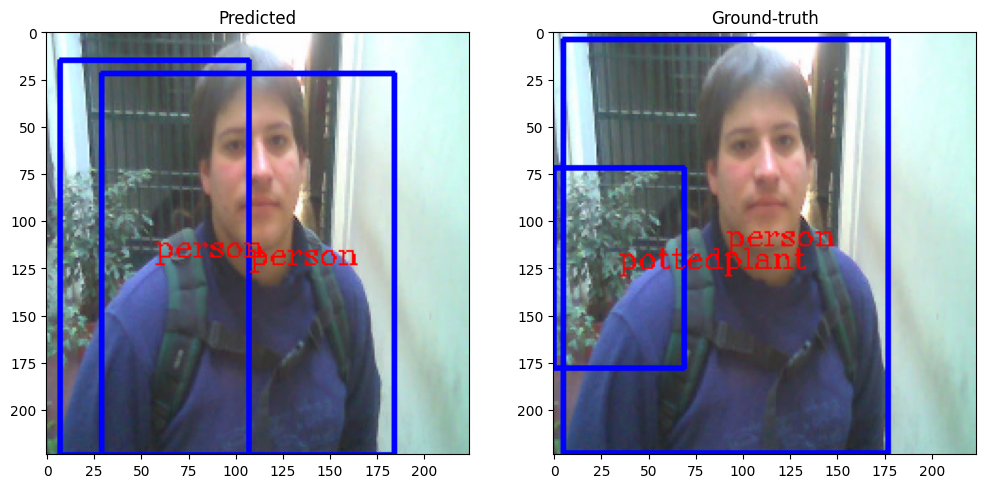

In [11]:
iou_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
x = x.to(device)
img_file = val_dataset.data_list[i].filename

model.eval()
prob_val, class_idx, bb_hat = model.predict(x.unsqueeze(0))

keep = nms(bb_hat, prob_val, iou_threshold)

bb_hat = bb_hat[keep, :].detach().cpu().numpy()
prob_val = prob_val[keep].detach().cpu().numpy()
class_idx = class_idx[keep].detach().cpu().numpy() + 1

width = bb_hat[:, 2] - bb_hat[:, 0]
height = bb_hat[:, 3] - bb_hat[:, 1]
bb_hat[:, 0] = bb_hat[:, 0] + width / 2
bb_hat[:, 1] = bb_hat[:, 1] + height / 2
bb_hat[:, 2] = width
bb_hat[:, 3] = height

output_bb = [PredBoundingBox(probability=prob_val[j],
                             class_id=class_idx[j],
                             classname=id_cat[class_idx[j]],
                             bounding_box=[bb_hat[j, 0],
                                           bb_hat[j, 1],
                                           bb_hat[j, 2],
                                           bb_hat[j, 3]])
             for j in range(len(prob_val))]

example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in output_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in output_bb], [bb.bounding_box for bb in output_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()